In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

Visualization dataset

In [83]:
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [84]:
df = pd.read_csv('trainingEmotion.csv', na_values='?', encoding='latin1',header=None,names=columns)


In [85]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [86]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [87]:
print(df.shape)
df.head(10)

(1600000, 6)


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [88]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

We will process only a part of the data, since some of the models take a lot of time, even in google collab.

In [89]:
from sklearn.model_selection import train_test_split

df_sampled, _ = train_test_split(df, test_size=0.95, stratify=df["target"], random_state=42)

Data preprocessing (noise and stopwords)

In [90]:
import re
import os
import sys
import json
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from bs4 import BeautifulSoup
import unicodedata
import en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer

In [91]:
def removeTags(x):
    return re.sub(r'@\w+',"", x)

def removeUrls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def removeEmails(x):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)

def removeSpecialChars(x):
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    return x

def removeHastag(x):
    return re.sub(r'#', '', x)

def removeRt(x):
    return re.sub(r'\brt\b', '', x).strip()
    
def removeAccentedChars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

def removeStopwords(x):
    return ' '.join([t for t in x.split() if t not in stopwords])

def removeDupsChar(x):
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [92]:
def dataClean(x):  
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = removeEmails(x)
    x = removeTags(x)
    x = removeHastag(x)
    x = removeStopwords(x)
    x = removeUrls(x)
    x = removeRt(x)
    x = removeDupsChar(x)
    x = removeAccentedChars(x)
    x = removeSpecialChars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [93]:
df_sampled["text"] = df_sampled["text"].apply(dataClean)

In [94]:
for tuit in df_sampled.iloc[0:5]["text"]:
    print(tuit)
    print("\n\n")

sleeping deberaa seguir durmiendo



sleepover fun im eating maltesers



good morning you oh no youve mutilated dont worry theyll grow back



track coming sendspace soon watching link xx



wish there here





Stemming.

In [95]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    return ' '.join(stemmer.stem(word) for word in text.split())

df_sampled['stemmed_text'] = df_sampled['text'].apply(stem_text)

In [96]:
y=df_sampled["target"]
X_trainB=df_sampled["stemmed_text"]

We also preprocess the test dataset.

In [97]:
#import and preprocess test set. 
df_test = pd.read_csv('testEmotion.csv', na_values='?', encoding='latin1',header=None,names=columns)


In [98]:
df_test.dtypes


target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [99]:
df_test['target'].value_counts()

target
4    182
0    177
2    139
Name: count, dtype: int64

In [100]:
df_test = df_test[df_test['target'] != 2]
df_test['target'].value_counts()

target
4    182
0    177
Name: count, dtype: int64

In [101]:
df_test.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [102]:
df_test["text"] = df_test["text"].apply(dataClean)
df_test['stemmed_text'] = df_test['text'].apply(stem_text)


In [103]:
#X_testB will be used for BOW and X_test for word embedding.
X_testB=df_test["stemmed_text"]
X_test=df_test["text"]

We build a BOW. It performs tokenization for us.

In [104]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

X_train_vect = vectorizer.fit_transform(X_trainB)
X_test_vect = vectorizer.transform(X_testB)


In [105]:
y_test=df_test["target"]

In [106]:
featureName = vectorizer.get_feature_names_out()
print("Number of features - ", len(featureName))
print("Last 30 features are\n", featureName[-30:])

Number of features -  47066
Last 30 features are
 ['zoomalbumdm' 'zoombezi' 'zoomtext' 'zoon' 'zoot' 'zoro' 'zorro' 'zot'
 'zpracovana' 'zq' 'zr' 'zs' 'zshare' 'zslater' 'zta' 'zu' 'zuckerburg'
 'zuda' 'zui' 'zuma' 'zumez' 'zune' 'zuneega' 'zup' 'zurich' 'zwitschert'
 'zx' 'zyah' 'zyrtec' 'zz']


In [107]:
vectorizer.vocabulary_

{'sleep': 37290,
 'deberaa': 11011,
 'seguir': 36017,
 'durmiendo': 12583,
 'sleepov': 37325,
 'fun': 15743,
 'im': 19988,
 'eat': 12796,
 'maltes': 24755,
 'good': 16793,
 'morn': 26545,
 'you': 46706,
 'oh': 28822,
 'no': 28098,
 'youv': 46805,
 'mutil': 27067,
 'dont': 12092,
 'worri': 45876,
 'theyll': 40614,
 'grow': 17278,
 'back': 4557,
 'track': 41784,
 'come': 9326,
 'sendspac': 36112,
 'soon': 37917,
 'watch': 44438,
 'link': 23548,
 'xx': 46305,
 'wish': 45444,
 'there': 40558,
 'here': 18480,
 'quotbelievequot': 32468,
 'raheem': 33599,
 'devaughnim': 11392,
 'zone': 47027,
 'phone': 30650,
 'die': 11540,
 'cant': 7718,
 'charg': 8282,
 'til': 40996,
 'hm': 18811,
 'tomorrow': 41457,
 'soo': 37912,
 'bit': 5889,
 'amp': 3188,
 'els': 13143,
 'safe': 35303,
 'night': 27886,
 'man': 24781,
 'el': 13048,
 'jay': 21089,
 'slow': 37414,
 'lay': 23016,
 'bed': 5265,
 'headach': 18192,
 'think': 40673,
 'of': 28749,
 'sorri': 37969,
 'left': 23158,
 'ill': 19933,
 'share': 36372,


In [108]:
#X_train_t=X_train.drop(["ids","flag","user","date"],axis=1)

SVM

In [109]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_vect, y)

MultinomialNB()

In [110]:
print("Accuracy Score on Train", clf.score(X_train_vect, y))

Accuracy Score on Train 0.8341375


In [111]:
from sklearn.svm import SVC #repetir cuando tenga todo el preprocessing bien, dura 25 mins o asi. 
import numpy as np
from sklearn.metrics import accuracy_score

"""svmpolynomial = SVC(gamma = 0.1, kernel = 'poly', random_state = 42)
svmpolynomial.fit(X_train_vect,y)"""


"svmpolynomial = SVC(gamma = 0.1, kernel = 'poly', random_state = 42)\nsvmpolynomial.fit(X_train_vect,y)"

In [112]:

"""import joblib
joblib.dump(svmpolynomial, 'svm_model.pkl')
print("Model saved in 'svm_model.pkl'.")
"""

'import joblib\njoblib.dump(svmpolynomial, \'svm_model.pkl\')\nprint("Model saved in \'svm_model.pkl\'.")\n'

In [113]:
""""""
import joblib
svmpolynomial = joblib.load('svm_model.pkl')
print("Model loaded correctly.")

Model loaded correctly.


In [114]:
labels_predict = svmpolynomial.predict(X_test_vect)

In [115]:
print(accuracy_score(y_test,labels_predict))

0.7103064066852368


In [116]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print("Confusion Matrix")
matrix = confusion_matrix(y_test,labels_predict, labels=[0,4])
print(matrix)

Confusion Matrix
[[ 90  87]
 [ 17 165]]


Axes(0.125,0.11;0.62x0.77)


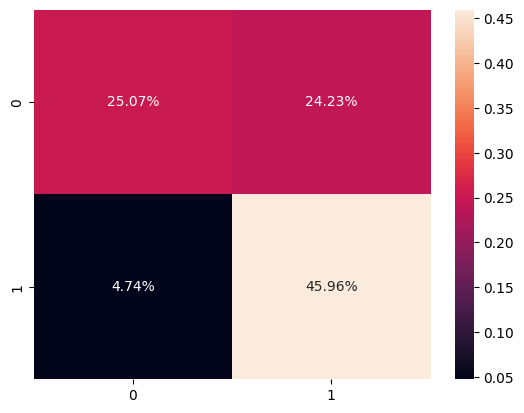

In [117]:
print(sns.heatmap(matrix/np.sum(matrix), annot=True,fmt='.2%'))

In [118]:
print("CLassification Report")
print(classification_report(df_test["target"], labels_predict,zero_division=0))

CLassification Report
              precision    recall  f1-score   support

           0       0.84      0.51      0.63       177
           4       0.65      0.91      0.76       182

    accuracy                           0.71       359
   macro avg       0.75      0.71      0.70       359
weighted avg       0.75      0.71      0.70       359



Decision Trees

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier = DecisionTreeClassifier()
classifier.fit(X_train_vect, y)


DecisionTreeClassifier()

In [120]:
y_pred = classifier.predict(X_test_vect)

In [121]:
print(accuracy_score(y_test,y_pred))

0.724233983286908


Confusion Matrix
Axes(0.125,0.11;0.62x0.77)


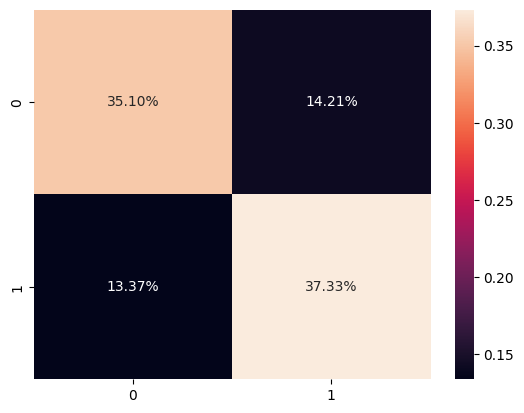

In [122]:
print("Confusion Matrix")
matrix = confusion_matrix(y_test,y_pred)
print(sns.heatmap(matrix/np.sum(matrix), annot=True,fmt='.2%'))

In [123]:
print("CLassification Report")
print(classification_report(y_test, y_pred))

CLassification Report
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       177
           4       0.72      0.74      0.73       182

    accuracy                           0.72       359
   macro avg       0.72      0.72      0.72       359
weighted avg       0.72      0.72      0.72       359



KNN

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
knn = KNeighborsClassifier(n_neighbors=10)

0.6935933147632312
Confusion Matrix
Axes(0.125,0.11;0.62x0.77)
CLassification Report
              precision    recall  f1-score   support

           0       0.68      0.71      0.70       177
           4       0.71      0.68      0.69       182

    accuracy                           0.69       359
   macro avg       0.69      0.69      0.69       359
weighted avg       0.69      0.69      0.69       359



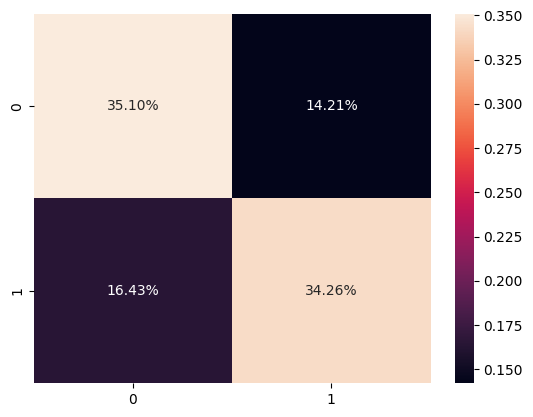

In [125]:
knn.fit(X_train_vect, y)
y_pred_knn = knn.predict(X_test_vect)
print(accuracy_score(y_test,y_pred_knn))
print("Confusion Matrix")
matrix = confusion_matrix(y_test,y_pred_knn)
print(sns.heatmap(matrix/np.sum(matrix), annot=True,fmt='.2%'))
print("CLassification Report")
print(classification_report(y_test, y_pred_knn))

Word Embedding and CNN

In [126]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

We will use text without stemming for word embedding with GloVe. Also, we will have to do tokenization manually.

In [127]:
X_train=df_sampled["text"]

encode to 0 and 1 so the Neural Network works well.

In [128]:
y = np.where(y == 4, 1, y)
y_test=np.where(y_test == 4, 1, y_test)

We do a new split so we have validation data. 

In [129]:
from sklearn.model_selection import train_test_split
X_trainC, X_valC, y_trainC, y_valC = train_test_split(X_train, y, test_size=0.2, random_state=42)

Tokenization

In [130]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_trainC)


In [131]:
vocab_size = len(tokenizer.word_index) + 1
max_length = 282  # Maximum sentence length for padding (Twitter has a maximum of 280 characters)
embedding_dim = 50  # Embedding dimension (match with your pre-trained embeddings)

In [132]:
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_trainC), maxlen=max_length, padding="post") 
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding="post")
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_valC), maxlen=max_length, padding="post")

In [133]:
import numpy as np

# Load GloVe embeddings
embedding_dict = {}
with open("glove.twitter.27B.50d.txt", "r", encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype="float32")
        embedding_dict[word] = vector

In [134]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    if word in embedding_dict:
        embedding_matrix[index] = embedding_dict[word]

Now CNN

In [135]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Convolution1D, Flatten, Dropout
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, MaxPooling1D, Flatten, Dense

In [ ]:


model = Sequential()

model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))

model.add(Convolution1D(64, 3, padding='same'))
model.add(Convolution1D(32, 3, padding='same'))
model.add(Convolution1D(16, 3, padding='same'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(180,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))



model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




C:\Users\quinito\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [137]:
history = model.fit(X_train_seq, y_trainC, epochs=10, batch_size=32, validation_data=(X_val_seq, y_valC))


Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.6698 - loss: 0.6057 - val_accuracy: 0.7049 - val_loss: 0.5548
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.7037 - loss: 0.5640 - val_accuracy: 0.7101 - val_loss: 0.5523
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7081 - loss: 0.5553 - val_accuracy: 0.7119 - val_loss: 0.5523
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7114 - loss: 0.5527 - val_accuracy: 0.7144 - val_loss: 0.5485
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7128 - loss: 0.5523 - val_accuracy: 0.7186 - val_loss: 0.5459
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7119 - loss: 0.5547 - val_accuracy: 0.7104 - val_loss: 0.5564
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7147 - loss: 0.5528 - val_accuracy: 0.7191 - val_loss: 0.5465
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7147 -

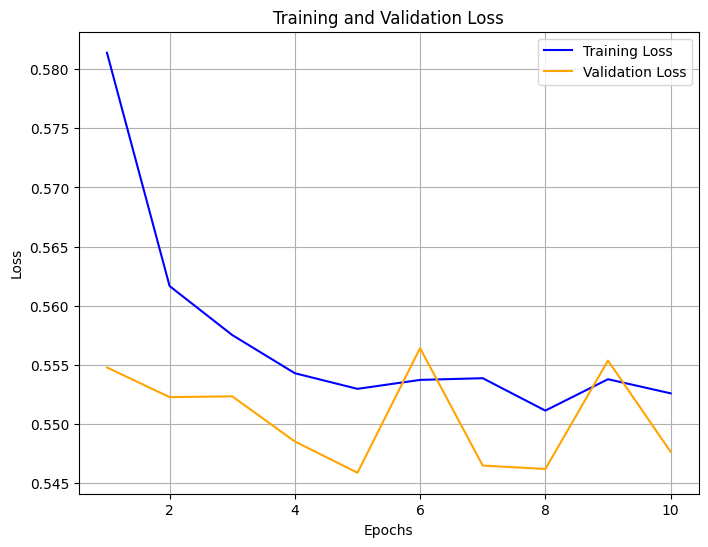

In [138]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Probably we could have been okay with 5 epochs.

In [139]:
y_pred_cnn = model.predict(X_test_seq)
print(y_pred_cnn)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.9176736 ]
 [0.91061676]
 [0.54471326]
 [0.5566193 ]
 [0.672638  ]
 [0.32134068]
 [0.11537919]
 [0.8941988 ]
 [0.6166456 ]
 [0.54716766]
 [0.35503605]
 [0.4704491 ]
 [0.820252  ]
 [0.38143134]
 [0.27068177]
 [0.3347447 ]
 [0.6410458 ]
 [0.40338424]
 [0.40338388]
 [0.47802803]
 [0.7521423 ]
 [0.42656365]
 [0.69774425]
 [0.29869825]
 [0.7258243 ]
 [0.40808243]
 [0.60323286]
 [0.7486222 ]
 [0.472296  ]
 [0.6279948 ]
 [0.2670372 ]
 [0.5224576 ]
 [0.04282013]
 [0.0418465 ]
 [0.09891094]
 [0.2249427 ]
 [0.43043575]
 [0.85483193]
 [0.4345432 ]
 [0.01363558]
 [0.16130286]
 [0.15526418]
 [0.17549244]
 [0.44752157]
 [0.54308534]
 [0.6969975 ]
 [0.39978227]
 [0.9336695 ]
 [0.7228116 ]
 [0.63415074]
 [0.16822968]
 [0.78803277]
 [0.7133095 ]
 [0.78708386]
 [0.5036818 ]
 [0.52875036]
 [0.76295924]
 [0.6805376 ]
 [0.4147237 ]
 [0.8565484 ]
 [0.7541494 ]
 [0.4017582 ]
 [0.4481113 ]
 [0.22871178]
 [0.8403172 ]
 [0.40754774]
 [0.8481678 ]
 [0.39739147]
 [0.1682

In [140]:
scores = model.evaluate(X_test_seq, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 77.44%


In [141]:
y_pred_cnn_binary = (y_pred_cnn >= 0.5).astype(int)

0.7743732590529248
Confusion Matrix
Axes(0.125,0.11;0.62x0.77)
CLassification Report
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       177
           1       0.80      0.74      0.77       182

    accuracy                           0.77       359
   macro avg       0.78      0.77      0.77       359
weighted avg       0.78      0.77      0.77       359



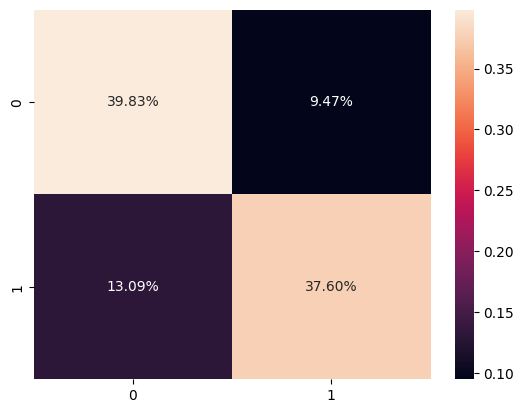

In [142]:
print(accuracy_score(y_test,y_pred_cnn_binary))
print("Confusion Matrix")
matrix = confusion_matrix(y_test,y_pred_cnn_binary)
print(sns.heatmap(matrix/np.sum(matrix), annot=True,fmt='.2%'))
print("CLassification Report")
print(classification_report(y_test, y_pred_cnn_binary))

In [143]:
model.save("model_cnn.keras")

Comparing of the models:

In [144]:
import pandas as pd
data = {'MODEL':['SVM','DT', 'KNN', 'CNN'],
        'ACCURACY':[71.03,72.144, 69.359, 77.44],
        }
df = pd.DataFrame(data)


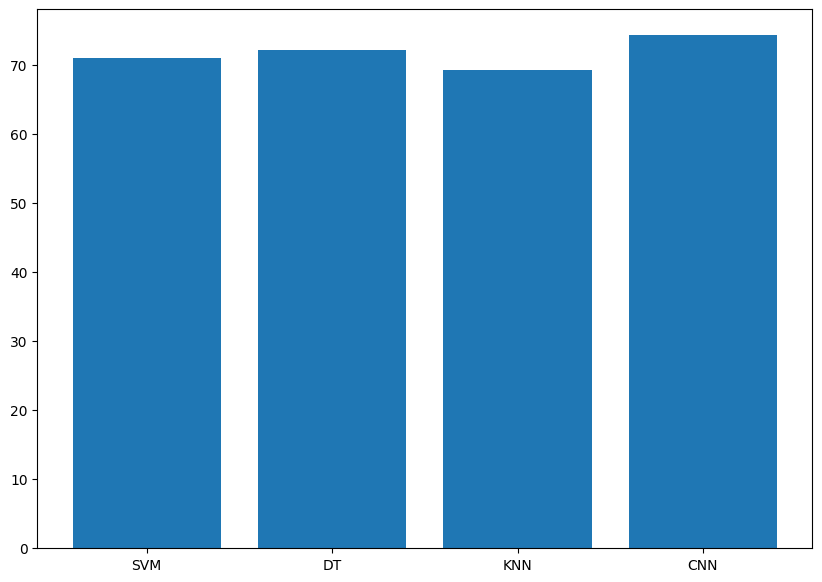

In [147]:
import pandas as pd
from matplotlib import pyplot as plt
name = df['MODEL']
price = df['ACCURACY']
fig = plt.figure(figsize =(10, 7))
plt.bar(name[0:6], price[0:6])
plt.show()

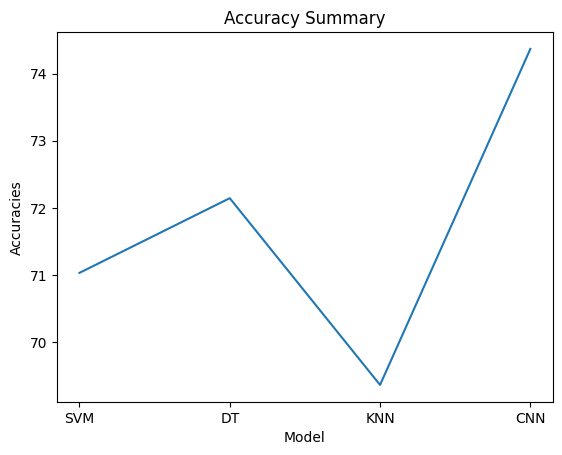

In [148]:
import matplotlib.pyplot as plt
x = name
y = price
plt.plot(x, y)
plt.xlabel('Model')
plt.ylabel('Accuracies')
plt.title('Accuracy Summary')
plt.show()